In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
!pip install tensorpack

%cd gdrive/MyDrive/SEAI_Project

     |████████████████████████████████| 296kB 4.0MB/s 
/content/gdrive/MyDrive/SEAI_Project


In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# File: svhn-digit-dorefa.py
# Author: Yuxin Wu

import argparse
import os
import tensorflow as tf

from tensorpack import *
from tensorpack.dataflow import dataset
from tensorpack.tfutils.summary import add_moving_summary, add_param_summary
from tensorpack.tfutils.varreplace import remap_variables

"""
This is a tensorpack script for the SVHN results in paper:
DoReFa-Net: Training Low Bitwidth Convolutional Neural Networks with Low Bitwidth Gradients
http://arxiv.org/abs/1606.06160
The original experiements are performed on a proprietary framework.
This is our attempt to reproduce it on tensorpack.
Accuracy:
    With (W,A,G)=(1,1,4), can reach 3.1~3.2% error after 150 epochs.
    With (W,A,G)=(1,2,4), error is 3.0~3.1%.
    With (W,A,G)=(32,32,32), error is about 2.3%.
Speed:
    With quantization, 60 batch/s on 1 1080Ti. (4721 batch / epoch)
To Run:
    ./svhn-digit-dorefa.py --dorefa 1,2,4
"""
tf.compat.v1.reset_default_graph()

BITW = 1
BITA = 2
BITG = 4

"""
imported from dorefa file
"""
def get_dorefa(bitW, bitA, bitG):
    """
    Return the three quantization functions fw, fa, fg, for weights, activations and gradients respectively
    """
    def quantize(x, k):
        n = float(2 ** k - 1)

        @tf.custom_gradient
        def _quantize(x):
            return tf.round(x * n) / n, lambda dy: dy

        return _quantize(x)

    def fw(x):
        if bitW == 32:
            return x

        if bitW == 1:   # BWN
            E = tf.stop_gradient(tf.reduce_mean(tf.abs(x)))

            @tf.custom_gradient
            def _sign(x):
                return tf.where(tf.equal(x, 0), tf.ones_like(x), tf.sign(x / E)) * E, lambda dy: dy

            return _sign(x)

        x = tf.tanh(x)
        x = x / tf.reduce_max(tf.abs(x)) * 0.5 + 0.5
        return 2 * quantize(x, bitW) - 1

    def fa(x):
        if bitA == 32:
            return x
        return quantize(x, bitA)

    def fg(x):
        if bitG == 32:
            return x

        @tf.custom_gradient
        def _identity(input):
            def grad_fg(x):
                rank = x.get_shape().ndims
                assert rank is not None
                maxx = tf.reduce_max(tf.abs(x), list(range(1, rank)), keepdims=True)
                x = x / maxx
                n = float(2**bitG - 1)
                x = x * 0.5 + 0.5 + tf.random.uniform(
                    tf.shape(x), minval=-0.5 / n, maxval=0.5 / n)
                x = tf.clip_by_value(x, 0.0, 1.0)
                x = quantize(x, bitG) - 0.5
                return x * maxx * 2

            return input, grad_fg

        return _identity(x)
    return fw, fa, fg


class Model(ModelDesc):
    def inputs(self):
        return [tf.TensorSpec([None, 40, 40, 3], tf.float32, 'input'),
                tf.TensorSpec([None], tf.int32, 'label')]

    def build_graph(self, image, label):
        fw, fa, fg = get_dorefa(BITW, BITA, BITG)

        # monkey-patch tf.get_variable to apply fw
        def binarize_weight(v):
            name = v.op.name
            # don't binarize first and last layer
            if not name.endswith('W'):
                return v
            else:
                logger.info("Binarizing weight {}".format(v.op.name))
                return fw(v)

        def nonlin(x):
            if BITA == 32:
                return tf.nn.relu(x)
            return tf.clip_by_value(x, 0.0, 1.0)

        def activate(x):
            return fa(nonlin(x))

        image = image / 256.0

        with remap_variables(binarize_weight), \
                argscope(BatchNorm, momentum=0.9, epsilon=1e-4), \
                argscope(Conv2D, use_bias=False):
            logits = (LinearWrap(image)
                      .Conv2D('conv0', 48, 5, padding='VALID', use_bias=True)
                      .MaxPooling('pool0', 2, padding='SAME')
                      .apply(activate)
                      # 18
                      .Conv2D('conv1', 64, 3, padding='SAME')
                      .apply(fg)
                      .BatchNorm('bn1').apply(activate)
#AVGPooling
                      .Conv2D('conv2', 64, 3, padding='SAME')
                      .apply(fg)
                      .BatchNorm('bn2')
                      .MaxPooling('pool1', 2, padding='SAME')
                      .apply(activate)
                      # 9
                      .Conv2D('conv3', 128, 3, padding='VALID')
                      .apply(fg)
                      .BatchNorm('bn3').apply(activate)
                      # 7

                      .Conv2D('conv4', 128, 3, padding='SAME')
                      .apply(fg)
                      .BatchNorm('bn4').apply(activate)

                      .Conv2D('conv5', 128, 3, padding='VALID')
                      .apply(fg)
                      .BatchNorm('bn5').apply(activate)
                      # 5
                      .Dropout(rate=0.5 if self.training else 0.0)
                      .Conv2D('conv6', 512, 5, padding='VALID')
                      .apply(fg).BatchNorm('bn6')
                      .apply(nonlin)
                      .FullyConnected('fc1', 10)())
        tf.nn.softmax(logits, name='output')

        correct = tf.cast(tf.nn.in_top_k(predictions=logits, targets=label, k=1), tf.float32, name='correct')
        accuracy = tf.reduce_mean(correct, name='accuracy')
        train_error = tf.reduce_mean(1 - correct, name='train_error')
        summary.add_moving_summary(train_error, accuracy)
        
        cost = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=label)
        cost = tf.reduce_mean(cost, name='cross_entropy_loss')
        # weight decay on all W of fc layers
        wd_cost = regularize_cost('fc.*/W', l2_regularizer(1e-7))
        add_param_summary(('.*/W', ['histogram', 'rms']))
        total_cost = tf.add_n([cost, wd_cost], name='cost')
        add_moving_summary(cost, wd_cost, total_cost)
        return total_cost

    def optimizer(self):
        lr = tf.compat.v1.train.exponential_decay(
            learning_rate=1e-3,
            global_step=get_global_step_var(),
            decay_steps=4721 * 100,
            decay_rate=0.5, staircase=True, name='learning_rate')
        tf.summary.scalar('lr', lr)

        return tf.compat.v1.train.AdamOptimizer(lr, epsilon=1e-5)


def get_config():
    logger.set_logger_dir(os.path.join('train_log', 'svhn-dorefa-{}'.format(args)))

    # prepare dataset
    d1 = dataset.SVHNDigit('train')
    d2 = dataset.SVHNDigit('extra')
    data_train = RandomMixData([d1, d2])
    data_test = dataset.SVHNDigit('test')

    augmentors = [
        imgaug.Resize((40, 40)),
        imgaug.Brightness(30),
        imgaug.Contrast((0.5, 1.5)),
    ]
    data_train = AugmentImageComponent(data_train, augmentors)
    data_train = BatchData(data_train, 128)
    data_train = MultiProcessRunnerZMQ(data_train, 5)

    augmentors = [imgaug.Resize((40, 40))]
    data_test = AugmentImageComponent(data_test, augmentors)
    data_test = BatchData(data_test, 128, remainder=True)

    return TrainConfig(
        data=QueueInput(data_train),
        callbacks=[
            ModelSaver(),
            InferenceRunner(    # run inference(for validation) after every epoch
                data_test,   # the DataFlow instance used for validation
                ScalarStats(    # produce `val_accuracy` and `val_cross_entropy_loss`
                    ['cross_entropy_loss', 'accuracy'], prefix='val'))
        ],
        model=Model(),
        max_epoch=10,
    )

args = "1,2,4"
BITW, BITA, BITG = map(int, args.split(','))
config = get_config()
launch_train_with_config(config, SimpleTrainer())

'''
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--dorefa',
                        help='number of bits for W,A,G, separated by comma. Defaults to \'1,2,4\'',
                        default='1,2,4')
    args = parser.parse_args()

    BITW, BITA, BITG = map(int, args.dorefa.split(','))
    config = get_config()
    launch_train_with_config(config, SimpleTrainer())
'''

[0716 08:50:32 @logger.py:128] WRN Log directory train_log/svhn-dorefa-1,2,4 exists! Use 'd' to delete it. 
[0716 08:50:32 @logger.py:131] WRN If you're resuming from a previous run, you can choose to keep it.
Press any other key to exit. 
Select Action: k (keep) / d (delete) / q (quit):k
[0716 08:50:34 @logger.py:85] Existing log file 'train_log/svhn-dorefa-1,2,4/log.log' backuped to 'train_log/svhn-dorefa-1,2,4/log.log.0716-085034'
[0716 08:50:34 @logger.py:92] Argv: /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-18d539d4-1d66-43ce-a39b-d510c5d550a3.json
[0716 08:50:34 @fs.py:101] WRN Env var $TENSORPACK_DATASET not set, using /root/tensorpack_data for datasets.
[0716 08:50:34 @fs.py:104] Created the directory /root/tensorpack_data.
[0716 08:50:34 @svhn.py:42] File /root/tensorpack_data/svhn_data/train_32x32.mat not found!
[0716 08:50:34 @svhn.py:43] Downloading from http://ufldl.stanford.edu/housenumbers/train_32x32.mat ...


train_32x32.mat: 182MB [00:12, 14.3MB/s]                           

[0716 08:50:47 @fs.py:73] Succesfully downloaded train_32x32.mat. 182040794 bytes.
[0716 08:50:47 @svhn.py:45] Loading /root/tensorpack_data/svhn_data/train_32x32.mat ...


[0716 08:50:48 @svhn.py:42] File /root/tensorpack_data/svhn_data/extra_32x32.mat not found!
[0716 08:50:48 @svhn.py:43] Downloading from http://ufldl.stanford.edu/housenumbers/extra_32x32.mat ...


extra_32x32.mat: 1.33GB [02:02, 10.8MB/s]                            

[0716 08:52:51 @fs.py:73] Succesfully downloaded extra_32x32.mat. 1329278602 bytes.
[0716 08:52:51 @svhn.py:45] Loading /root/tensorpack_data/svhn_data/extra_32x32.mat ...


[0716 08:53:03 @svhn.py:42] File /root/tensorpack_data/svhn_data/test_32x32.mat not found!
[0716 08:53:03 @svhn.py:43] Downloading from http://ufldl.stanford.edu/housenumbers/test_32x32.mat ...


test_32x32.mat: 64.3MB [00:00, 75.4MB/s]                            

[0716 08:53:04 @fs.py:73] Succesfully downloaded test_32x32.mat. 64275384 bytes.
[0716 08:53:04 @svhn.py:45] Loading /root/tensorpack_data/svhn_data/test_32x32.mat ...


[0716 08:53:05 @parallel.py:340] [MultiProcessRunnerZMQ] Will fork a dataflow more than one times. This assumes the datapoints are i.i.d.
[0716 08:53:05 @input_source.py:221] Setting up the queue 'QueueInput/input_queue' for CPU prefetching ...
[0716 08:53:05 @trainers.py:48] Building graph for a single training tower ...
[0716 08:53:05 @<ipython-input-3-ac085d8d8c77>:113] Binarizing weight conv0/W
[0716 08:53:05 @registry.py:90] 'conv0': [?, 40, 40, 3] --> [?, 36, 36, 48]
[0716 08:53:05 @registry.py:90] 'pool0': [?, 36, 36, 48] --> [?, 18, 18, 48]
[0716 08:53:05 @<ipython-input-3-ac085d8d8c77>:113] Binarizing weight conv1/W
[0716 08:53:05 @registry.py:90] 'conv1': [?, 18, 18, 48] --> [?, 18, 18, 64]
[0716 08:53:05 @<ipython-input-3-ac085d8d8c77>:113] Binarizing weight conv2/W
[0716 08:53:05 @registry.py:90] 'conv2': [?, 18, 18, 64] --> [?, 18, 18, 64]
[0716 08:53:05 @registry.py:90] 'pool1': [?, 18, 18, 64] --> [?, 9, 9, 64]
[0716 08:53:05 @<ipython-input-3-ac085d8d8c77>:113] Binarizi

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


[0716 08:53:05 @<ipython-input-3-ac085d8d8c77>:113] Binarizing weight conv4/W
[0716 08:53:05 @registry.py:90] 'conv4': [?, 7, 7, 128] --> [?, 7, 7, 128]
[0716 08:53:05 @<ipython-input-3-ac085d8d8c77>:113] Binarizing weight conv5/W
[0716 08:53:05 @registry.py:90] 'conv5': [?, 7, 7, 128] --> [?, 5, 5, 128]
[0716 08:53:05 @<ipython-input-3-ac085d8d8c77>:113] Binarizing weight conv6/W
[0716 08:53:05 @registry.py:90] 'conv6': [?, 5, 5, 128] --> [?, 1, 1, 512]
[0716 08:53:05 @<ipython-input-3-ac085d8d8c77>:113] Binarizing weight fc1/W
[0716 08:53:05 @registry.py:90] 'fc1': [?, 1, 1, 512] --> [?, 10]
[0716 08:53:05 @regularize.py:97] regularize_cost() found 1 variables to regularize.
[0716 08:53:05 @regularize.py:21] The following tensors will be regularized: fc1/W:0
[0716 08:53:06 @model_utils.py:67] List of Trainable Variables: 
name       shape               #elements
---------  ----------------  -----------
conv0/W    [5, 5, 3, 48]            3600
conv0/b    [48]                       48


100%|##########|4721/4721[04:32<00:00,17.33it/s]

[0716 08:57:48 @base.py:283] Epoch 1 (global_step 4721) finished, time:4 minutes 32 seconds.


[0716 08:57:49 @saver.py:82] Model saved to train_log/svhn-dorefa-1,2,4/model-4721.


100%|##########|204/204[00:10<00:00,18.78it/s]

[0716 08:58:00 @monitor.py:476] QueueInput/queue_size: 18.5
[0716 08:58:00 @monitor.py:476] accuracy: 0.93954
[0716 08:58:00 @monitor.py:476] cost: 0.19235
[0716 08:58:00 @monitor.py:476] cross_entropy_loss: 0.19235
[0716 08:58:00 @monitor.py:476] param-summary/conv0/W-rms: 0.17857
[0716 08:58:00 @monitor.py:476] param-summary/conv1/W-rms: 0.079199
[0716 08:58:00 @monitor.py:476] param-summary/conv2/W-rms: 0.07235
[0716 08:58:00 @monitor.py:476] param-summary/conv3/W-rms: 0.076633
[0716 08:58:00 @monitor.py:476] param-summary/conv4/W-rms: 0.064322
[0716 08:58:00 @monitor.py:476] param-summary/conv5/W-rms: 0.068795
[0716 08:58:00 @monitor.py:476] param-summary/conv6/W-rms: 0.054514
[0716 08:58:00 @monitor.py:476] param-summary/fc1/W-rms: 0.11781
[0716 08:58:00 @monitor.py:476] regularize_cost: 3.5461e-06
[0716 08:58:00 @monitor.py:476] train_error: 0.060463
[0716 08:58:00 @monitor.py:476] val_accuracy: 0.91617
[0716 08:58:00 @monitor.py:476] val_cross_entropy_loss: 0.28432
[0716 08:58:0


100%|##########|4721/4721[04:02<00:00,19.43it/s]

[0716 09:02:03 @base.py:283] Epoch 2 (global_step 9442) finished, time:4 minutes 2 seconds.
[0716 09:02:03 @saver.py:82] Model saved to train_log/svhn-dorefa-1,2,4/model-9442.



100%|##########|204/204[00:09<00:00,20.71it/s]

[0716 09:02:13 @monitor.py:476] QueueInput/queue_size: 0.12891
[0716 09:02:13 @monitor.py:476] accuracy: 0.96312
[0716 09:02:13 @monitor.py:476] cost: 0.13418
[0716 09:02:13 @monitor.py:476] cross_entropy_loss: 0.13418
[0716 09:02:13 @monitor.py:476] param-summary/conv0/W-rms: 0.20262
[0716 09:02:13 @monitor.py:476] param-summary/conv1/W-rms: 0.090748
[0716 09:02:13 @monitor.py:476] param-summary/conv2/W-rms: 0.091948
[0716 09:02:13 @monitor.py:476] param-summary/conv3/W-rms: 0.1009
[0716 09:02:13 @monitor.py:476] param-summary/conv4/W-rms: 0.090162
[0716 09:02:13 @monitor.py:476] param-summary/conv5/W-rms: 0.096091
[0716 09:02:13 @monitor.py:476] param-summary/conv6/W-rms: 0.080982
[0716 09:02:13 @monitor.py:476] param-summary/fc1/W-rms: 0.15553
[0716 09:02:13 @monitor.py:476] regularize_cost: 6.1848e-06
[0716 09:02:13 @monitor.py:476] train_error: 0.036875
[0716 09:02:13 @monitor.py:476] val_accuracy: 0.93571
[0716 09:02:13 @monitor.py:476] val_cross_entropy_loss: 0.22623
[0716 09:02


100%|##########|4721/4721[04:04<00:00,19.29it/s]

[0716 09:06:18 @base.py:283] Epoch 3 (global_step 14163) finished, time:4 minutes 4 seconds.
[0716 09:06:18 @saver.py:82] Model saved to train_log/svhn-dorefa-1,2,4/model-14163.



100%|##########|204/204[00:09<00:00,21.05it/s]

[0716 09:06:28 @monitor.py:476] QueueInput/queue_size: 3.4712e-18
[0716 09:06:28 @monitor.py:476] accuracy: 0.96612
[0716 09:06:28 @monitor.py:476] cost: 0.1204
[0716 09:06:28 @monitor.py:476] cross_entropy_loss: 0.1204
[0716 09:06:28 @monitor.py:476] param-summary/conv0/W-rms: 0.22794
[0716 09:06:28 @monitor.py:476] param-summary/conv1/W-rms: 0.10747
[0716 09:06:28 @monitor.py:476] param-summary/conv2/W-rms: 0.11461
[0716 09:06:28 @monitor.py:476] param-summary/conv3/W-rms: 0.12329
[0716 09:06:28 @monitor.py:476] param-summary/conv4/W-rms: 0.11415
[0716 09:06:28 @monitor.py:476] param-summary/conv5/W-rms: 0.12005
[0716 09:06:28 @monitor.py:476] param-summary/conv6/W-rms: 0.10284
[0716 09:06:28 @monitor.py:476] param-summary/fc1/W-rms: 0.18546
[0716 09:06:28 @monitor.py:476] regularize_cost: 8.7961e-06
[0716 09:06:28 @monitor.py:476] train_error: 0.033877
[0716 09:06:28 @monitor.py:476] val_accuracy: 0.9477
[0716 09:06:28 @monitor.py:476] val_cross_entropy_loss: 0.19244
[0716 09:06:28 


100%|##########|4721/4721[04:04<00:00,19.34it/s]

[0716 09:10:32 @base.py:283] Epoch 4 (global_step 18884) finished, time:4 minutes 4 seconds.
[0716 09:10:32 @saver.py:82] Model saved to train_log/svhn-dorefa-1,2,4/model-18884.



100%|##########|204/204[00:09<00:00,20.89it/s]

[0716 09:10:42 @monitor.py:476] QueueInput/queue_size: 0.25202
[0716 09:10:42 @monitor.py:476] accuracy: 0.97317
[0716 09:10:42 @monitor.py:476] cost: 0.095692
[0716 09:10:42 @monitor.py:476] cross_entropy_loss: 0.095681
[0716 09:10:42 @monitor.py:476] param-summary/conv0/W-rms: 0.24616
[0716 09:10:42 @monitor.py:476] param-summary/conv1/W-rms: 0.12228
[0716 09:10:42 @monitor.py:476] param-summary/conv2/W-rms: 0.13495
[0716 09:10:42 @monitor.py:476] param-summary/conv3/W-rms: 0.14445
[0716 09:10:42 @monitor.py:476] param-summary/conv4/W-rms: 0.13493
[0716 09:10:42 @monitor.py:476] param-summary/conv5/W-rms: 0.14131
[0716 09:10:42 @monitor.py:476] param-summary/conv6/W-rms: 0.1215
[0716 09:10:42 @monitor.py:476] param-summary/fc1/W-rms: 0.21029
[0716 09:10:42 @monitor.py:476] regularize_cost: 1.1308e-05
[0716 09:10:42 @monitor.py:476] train_error: 0.026835
[0716 09:10:42 @monitor.py:476] val_accuracy: 0.94843
[0716 09:10:42 @monitor.py:476] val_cross_entropy_loss: 0.19062
[0716 09:10:42


100%|##########|4721/4721[04:06<00:00,19.12it/s]

[0716 09:14:49 @base.py:283] Epoch 5 (global_step 23605) finished, time:4 minutes 6 seconds.
[0716 09:14:49 @saver.py:82] Model saved to train_log/svhn-dorefa-1,2,4/model-23605.



100%|##########|204/204[00:09<00:00,22.47it/s]

[0716 09:14:58 @monitor.py:476] QueueInput/queue_size: 1.7764e-15
[0716 09:14:58 @monitor.py:476] accuracy: 0.97028
[0716 09:14:58 @monitor.py:476] cost: 0.10356
[0716 09:14:58 @monitor.py:476] cross_entropy_loss: 0.10354
[0716 09:14:58 @monitor.py:476] param-summary/conv0/W-rms: 0.25944
[0716 09:14:58 @monitor.py:476] param-summary/conv1/W-rms: 0.13646
[0716 09:14:58 @monitor.py:476] param-summary/conv2/W-rms: 0.15372
[0716 09:14:58 @monitor.py:476] param-summary/conv3/W-rms: 0.16298
[0716 09:14:58 @monitor.py:476] param-summary/conv4/W-rms: 0.15452
[0716 09:14:58 @monitor.py:476] param-summary/conv5/W-rms: 0.16015
[0716 09:14:58 @monitor.py:476] param-summary/conv6/W-rms: 0.13771
[0716 09:14:58 @monitor.py:476] param-summary/fc1/W-rms: 0.23453
[0716 09:14:58 @monitor.py:476] regularize_cost: 1.4078e-05
[0716 09:14:58 @monitor.py:476] train_error: 0.029715
[0716 09:14:58 @monitor.py:476] val_accuracy: 0.95577
[0716 09:14:58 @monitor.py:476] val_cross_entropy_loss: 0.16873
[0716 09:14:


100%|##########|4721/4721[04:10<00:00,18.88it/s]

[0716 09:19:08 @base.py:283] Epoch 6 (global_step 28326) finished, time:4 minutes 10 seconds.
[0716 09:19:09 @saver.py:82] Model saved to train_log/svhn-dorefa-1,2,4/model-28326.



100%|##########|204/204[00:10<00:00,19.17it/s]

[0716 09:19:19 @monitor.py:476] QueueInput/queue_size: 4.7685e-07
[0716 09:19:19 @monitor.py:476] accuracy: 0.97282
[0716 09:19:19 @monitor.py:476] cost: 0.10243
[0716 09:19:19 @monitor.py:476] cross_entropy_loss: 0.10242
[0716 09:19:19 @monitor.py:476] param-summary/conv0/W-rms: 0.27321
[0716 09:19:19 @monitor.py:476] param-summary/conv1/W-rms: 0.15092
[0716 09:19:19 @monitor.py:476] param-summary/conv2/W-rms: 0.17099
[0716 09:19:19 @monitor.py:476] param-summary/conv3/W-rms: 0.18061
[0716 09:19:19 @monitor.py:476] param-summary/conv4/W-rms: 0.17161
[0716 09:19:19 @monitor.py:476] param-summary/conv5/W-rms: 0.17827
[0716 09:19:19 @monitor.py:476] param-summary/conv6/W-rms: 0.1523
[0716 09:19:19 @monitor.py:476] param-summary/fc1/W-rms: 0.25992
[0716 09:19:19 @monitor.py:476] regularize_cost: 1.7297e-05
[0716 09:19:19 @monitor.py:476] train_error: 0.02718
[0716 09:19:19 @monitor.py:476] val_accuracy: 0.95646
[0716 09:19:19 @monitor.py:476] val_cross_entropy_loss: 0.16595
[0716 09:19:19


100%|##########|4721/4721[04:10<00:00,18.88it/s]

[0716 09:23:29 @base.py:283] Epoch 7 (global_step 33047) finished, time:4 minutes 10 seconds.
[0716 09:23:30 @saver.py:82] Model saved to train_log/svhn-dorefa-1,2,4/model-33047.



100%|##########|204/204[00:10<00:00,19.62it/s]

[0716 09:23:40 @monitor.py:476] QueueInput/queue_size: 5.5511e-17
[0716 09:23:40 @monitor.py:476] accuracy: 0.97015
[0716 09:23:40 @monitor.py:476] cost: 0.09472


[0716 09:23:40 @monitor.py:476] cross_entropy_loss: 0.094699
[0716 09:23:40 @monitor.py:476] param-summary/conv0/W-rms: 0.28546
[0716 09:23:40 @monitor.py:476] param-summary/conv1/W-rms: 0.15981
[0716 09:23:40 @monitor.py:476] param-summary/conv2/W-rms: 0.18487
[0716 09:23:40 @monitor.py:476] param-summary/conv3/W-rms: 0.19772
[0716 09:23:40 @monitor.py:476] param-summary/conv4/W-rms: 0.18815
[0716 09:23:40 @monitor.py:476] param-summary/conv5/W-rms: 0.19473
[0716 09:23:40 @monitor.py:476] param-summary/conv6/W-rms: 0.16554
[0716 09:23:40 @monitor.py:476] param-summary/fc1/W-rms: 0.28491
[0716 09:23:40 @monitor.py:476] regularize_cost: 2.0757e-05
[0716 09:23:40 @monitor.py:476] train_error: 0.029847
[0716 09:23:40 @monitor.py:476] val_accuracy: 0.9598
[0716 09:23:40 @monitor.py:476] val_cross_entropy_loss: 0.15976
[0716 09:23:40 @group.py:44] Callbacks took 10.724 sec in total. InferenceRunner: 10.4 seconds
[0716 09:23:40 @base.py:273] Start Epoch 8 ...


100%|##########|4721/4721[04:07<00:00,19.05it/s]

[0716 09:27:48 @base.py:283] Epoch 8 (global_step 37768) finished, time:4 minutes 7 seconds.
[0716 09:27:48 @saver.py:82] Model saved to train_log/svhn-dorefa-1,2,4/model-37768.



100%|##########|204/204[00:09<00:00,20.98it/s]

[0716 09:27:58 @monitor.py:476] QueueInput/queue_size: 7.8715e-06
[0716 09:27:58 @monitor.py:476] accuracy: 0.97729
[0716 09:27:58 @monitor.py:476] cost: 0.077121
[0716 09:27:58 @monitor.py:476] cross_entropy_loss: 0.077096
[0716 09:27:58 @monitor.py:476] param-summary/conv0/W-rms: 0.29699


[0716 09:27:58 @monitor.py:476] param-summary/conv1/W-rms: 0.17816
[0716 09:27:58 @monitor.py:476] param-summary/conv2/W-rms: 0.20251
[0716 09:27:58 @monitor.py:476] param-summary/conv3/W-rms: 0.21469
[0716 09:27:58 @monitor.py:476] param-summary/conv4/W-rms: 0.2031
[0716 09:27:58 @monitor.py:476] param-summary/conv5/W-rms: 0.21015
[0716 09:27:58 @monitor.py:476] param-summary/conv6/W-rms: 0.17784
[0716 09:27:58 @monitor.py:476] param-summary/fc1/W-rms: 0.30908
[0716 09:27:58 @monitor.py:476] regularize_cost: 2.4437e-05
[0716 09:27:58 @monitor.py:476] train_error: 0.022711
[0716 09:27:58 @monitor.py:476] val_accuracy: 0.96147
[0716 09:27:58 @monitor.py:476] val_cross_entropy_loss: 0.15256
[0716 09:27:58 @group.py:44] Callbacks took 9.995 sec in total. InferenceRunner: 9.74 seconds
[0716 09:27:58 @base.py:273] Start Epoch 9 ...


100%|##########|4721/4721[04:04<00:00,19.30it/s]

[0716 09:32:03 @base.py:283] Epoch 9 (global_step 42489) finished, time:4 minutes 4 seconds.
[0716 09:32:03 @saver.py:82] Model saved to train_log/svhn-dorefa-1,2,4/model-42489.



100%|##########|204/204[00:09<00:00,21.49it/s]

[0716 09:32:12 @monitor.py:476] QueueInput/queue_size: 0.52345
[0716 09:32:12 @monitor.py:476] accuracy: 0.97825
[0716 09:32:12 @monitor.py:476] cost: 0.081203
[0716 09:32:12 @monitor.py:476] cross_entropy_loss: 0.081175
[0716 09:32:12 @monitor.py:476] param-summary/conv0/W-rms: 0.30721
[0716 09:32:12 @monitor.py:476] param-summary/conv1/W-rms: 0.18821
[0716 09:32:12 @monitor.py:476] param-summary/conv2/W-rms: 0.21794
[0716 09:32:12 @monitor.py:476] param-summary/conv3/W-rms: 0.22894
[0716 09:32:12 @monitor.py:476] param-summary/conv4/W-rms: 0.21775
[0716 09:32:12 @monitor.py:476] param-summary/conv5/W-rms: 0.22531
[0716 09:32:12 @monitor.py:476] param-summary/conv6/W-rms: 0.1895
[0716 09:32:12 @monitor.py:476] param-summary/fc1/W-rms: 0.33176
[0716 09:32:12 @monitor.py:476] regularize_cost: 2.8147e-05
[0716 09:32:12 @monitor.py:476] train_error: 0.021753
[0716 09:32:12 @monitor.py:476] val_accuracy: 0.95782
[0716 09:32:12 @monitor.py:476] val_cross_entropy_loss: 0.15981
[0716 09:32:12


100%|##########|4721/4721[04:07<00:00,19.04it/s]

[0716 09:36:20 @base.py:283] Epoch 10 (global_step 47210) finished, time:4 minutes 7 seconds.
[0716 09:36:20 @saver.py:82] Model saved to train_log/svhn-dorefa-1,2,4/model-47210.



100%|##########|204/204[00:09<00:00,21.63it/s]

[0716 09:36:30 @monitor.py:476] QueueInput/queue_size: 1.9073e-06
[0716 09:36:30 @monitor.py:476] accuracy: 0.97878
[0716 09:36:30 @monitor.py:476] cost: 0.075832
[0716 09:36:30 @monitor.py:476] cross_entropy_loss: 0.0758
[0716 09:36:30 @monitor.py:476] param-summary/conv0/W-rms: 0.3158
[0716 09:36:30 @monitor.py:476] param-summary/conv1/W-rms: 0.20117
[0716 09:36:30 @monitor.py:476] param-summary/conv2/W-rms: 0.23085
[0716 09:36:30 @monitor.py:476] param-summary/conv3/W-rms: 0.24327
[0716 09:36:30 @monitor.py:476] param-summary/conv4/W-rms: 0.23125
[0716 09:36:30 @monitor.py:476] param-summary/conv5/W-rms: 0.23966
[0716 09:36:30 @monitor.py:476] param-summary/conv6/W-rms: 0.20037
[0716 09:36:30 @monitor.py:476] param-summary/fc1/W-rms: 0.35578
[0716 09:36:30 @monitor.py:476] regularize_cost: 3.2392e-05
[0716 09:36:30 @monitor.py:476] train_error: 0.021218
[0716 09:36:30 @monitor.py:476] val_accuracy: 0.96136
[0716 09:36:30 @monitor.py:476] val_cross_entropy_loss: 0.15088
[0716 09:36:3

"\nif __name__ == '__main__':\n    parser = argparse.ArgumentParser()\n    parser.add_argument('--dorefa',\n                        help='number of bits for W,A,G, separated by comma. Defaults to '1,2,4'',\n                        default='1,2,4')\n    args = parser.parse_args()\n\n    BITW, BITA, BITG = map(int, args.dorefa.split(','))\n    config = get_config()\n    launch_train_with_config(config, SimpleTrainer())\n"

<Figure size 432x288 with 0 Axes>

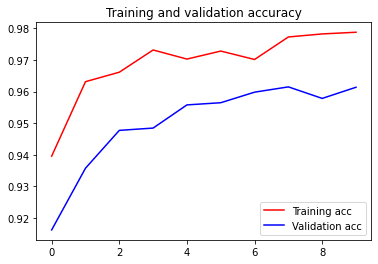

<Figure size 432x288 with 0 Axes>

In [3]:
import json
import matplotlib.pyplot as plt

f = open("train_log/svhn-dorefa-1,2,4/stats_def_first&last.json","r")

data = json.load(f)
accuracy = []
val_accuracy = []
for ob in data:
  accuracy.append(ob["accuracy"])
  val_accuracy.append(ob["val_accuracy"])

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training acc')
plt.plot(epochs, val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

In [14]:
from tabulate import tabulate
import matplotlib.pyplot as plt

ep = [i+1 for i in epochs]
table_acc = {"Epochs" : ep, "Accuracy":accuracy}
table_val_acc = {"Epochs" : ep, "Accuracy":val_accuracy}

print("ACCURACY\n")
print(tabulate(table_acc, headers='keys', tablefmt='fancy_grid'))
print("\nVALIDATION ACCURACY\n")
print(tabulate(table_val_acc, headers='keys', tablefmt='fancy_grid'))

ACCURACY

╒══════════╤════════════╕
│   Epochs │   Accuracy │
╞══════════╪════════════╡
│        1 │   0.939537 │
├──────────┼────────────┤
│        2 │   0.963125 │
├──────────┼────────────┤
│        3 │   0.966123 │
├──────────┼────────────┤
│        4 │   0.973165 │
├──────────┼────────────┤
│        5 │   0.970285 │
├──────────┼────────────┤
│        6 │   0.97282  │
├──────────┼────────────┤
│        7 │   0.970153 │
├──────────┼────────────┤
│        8 │   0.977289 │
├──────────┼────────────┤
│        9 │   0.978247 │
├──────────┼────────────┤
│       10 │   0.978782 │
╘══════════╧════════════╛

VALIDATION ACCURACY

╒══════════╤════════════╕
│   Epochs │   Accuracy │
╞══════════╪════════════╡
│        1 │   0.916169 │
├──────────┼────────────┤
│        2 │   0.935713 │
├──────────┼────────────┤
│        3 │   0.9477   │
├──────────┼────────────┤
│        4 │   0.948427 │
├──────────┼────────────┤
│        5 │   0.955767 │
├──────────┼────────────┤
│        6 │   0.956457 │
├─────